In [1]:
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn import naive_bayes #import GaussianNB, MultinomialNB
from sklearn.linear_model import SGDClassifier # simulate the behavior of logistic regression using SGDClassifier(loss='log')
from sklearn.metrics import accuracy_score,balanced_accuracy_score,average_precision_score, classification_report

from sklearn.utils import shuffle
from collections import Counter

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
train_df = pd.read_csv('cfpb_train.csv')
test_df = pd.read_csv('cfpb_test.csv')
dev_df = pd.read_csv('cfpb_dev.csv')

train_df['Consumer complaint narrative'] = train_df['Consumer complaint narrative'].fillna('').astype(str)
test_df['Consumer complaint narrative'] = test_df['Consumer complaint narrative'].fillna('').astype(str)
dev_df['Consumer complaint narrative'] = dev_df['Consumer complaint narrative'].fillna('').astype(str)

train_df['debt_collection'] = (train_df['Product'] == 'Debt collection').astype(int)
test_df['debt_collection'] = (test_df['Product'] == 'Debt collection').astype(int)
dev_df['debt_collection'] = (dev_df['Product'] == 'Debt collection').astype(int)

train_df_sample = train_df.sample(10000)

C:\Users\JYM\AppData\Local\Temp/ipykernel_2628/570579869.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('cfpb_train.csv')
C:\Users\JYM\AppData\Local\Temp/ipykernel_2628/570579869.py:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  dev_df = pd.read_csv('cfpb_dev.csv')


In [4]:
# Load the trained vectorizer
with open('tfidf_vectorizer_train_split_33k.pkl', 'rb') as f:
    loaded_vectorizer = pickle.load(f)
len(loaded_vectorizer.get_feature_names_out())

30288

In [5]:
%%time
# Vectorize the text data with pre-tuned vectorizer
X_train = loaded_vectorizer.transform(train_df['Consumer complaint narrative'])
y_train = train_df['debt_collection']

X_train_sample = loaded_vectorizer.transform(train_df_sample['Consumer complaint narrative'])
y_train_sample = train_df_sample['debt_collection']

X_dev = loaded_vectorizer.transform(dev_df['Consumer complaint narrative'])
y_dev = dev_df['debt_collection']

X_test = loaded_vectorizer.transform(test_df['Consumer complaint narrative'])
y_test = test_df['debt_collection']

Wall time: 3min 47s


In [6]:
%%time
selector = SelectKBest(chi2, k=30000)
X_train = selector.fit_transform(X_train, y_train)
X_train_sample = selector.transform(X_train_sample)
X_dev = selector.transform(X_dev)
X_test = selector.transform(X_test)

Wall time: 475 ms


In [7]:
%%time
# some balancing
# from imblearn.over_sampling import SMOTE 
# sm = SMOTE(random_state=42)
# X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
# # Shuffle your data
# X_train_res, y_train_res = shuffle(X_train_res, y_train_res)
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
X_train_res, y_train_res = oversample.fit_resample(X_train, y_train)

Wall time: 320 ms


### SGD Logistic Regression

In [8]:
# Shuffle your data
X_train_res, y_train_res = shuffle(X_train_res, y_train_res)

# Initialize a LogisticRegression model, ‘log_loss’ gives logistic regression, a probabilistic classifier.
clf= SGDClassifier(loss='log_loss',random_state=42, alpha=1e-4, n_iter_no_change=3, early_stopping=False)

# The partial fit if you ran out of RAM
batch_size = 50000
n_batches = X_train_res.shape[0] // batch_size

# partial fitting
for i in tqdm(range(n_batches)):
    start = i * batch_size
    end = (i + 1) * batch_size
    batch_X = X_train_res[start:end]
    batch_y = y_train_res[start:end]
    if i == 0:
        clf.partial_fit(batch_X.A, batch_y, classes=np.unique(y_train_res)) 
        # The `.A` here converts the sparse matrix to a dense matrix.
        # This is necessary because GaussianNB doesn't support sparse matrices.
        # We also specify the classes parameter in the first call to partial_fit.
    else:
        clf.partial_fit(batch_X.A, batch_y)

100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [05:36<00:00, 12.46s/it]


Train
accuracy_score 0.9021
balanced_accuracy_score 0.8686867315035476
average_precision_score 0.5977320023883328
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      8211
           1       0.69      0.82      0.75      1789

    accuracy                           0.90     10000
   macro avg       0.83      0.87      0.84     10000
weighted avg       0.91      0.90      0.91     10000

Prediction [(0, 7888), (1, 2112)]
Ground Truth [(0, 8211), (1, 1789)]


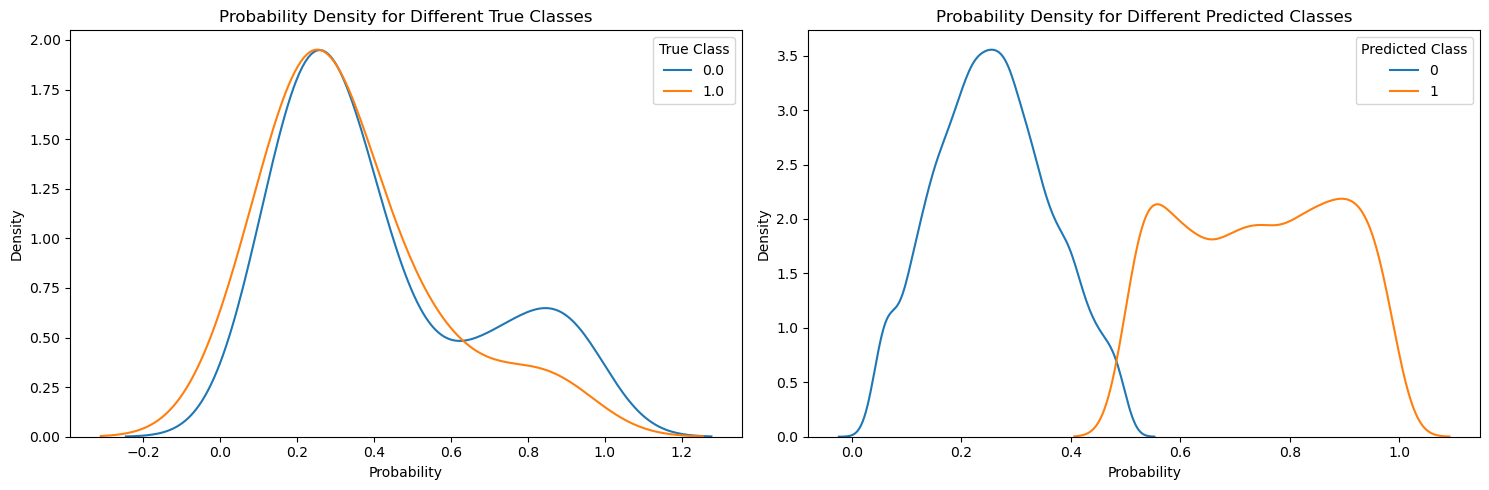

In [9]:
# get the results
y_pred = clf.predict(X_train_sample.toarray())
y_pred_proba = clf.predict_proba(X_train_sample.toarray())

# Convert lists to arrays for further use
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

print("Train")
print("accuracy_score",accuracy_score(y_train_sample, y_pred))
print("balanced_accuracy_score",balanced_accuracy_score(y_train_sample, y_pred))
print("average_precision_score",average_precision_score(y_train_sample, y_pred))
print(classification_report(y_train_sample, y_pred))

c = Counter(y_pred)
print("Prediction", c.most_common(2))
c = Counter(y_train_sample)
print("Ground Truth",c.most_common(2))

prediction = pd.DataFrame(y_pred_proba)
prediction['result'] = y_pred

df = prediction.copy()
df.columns = ['neg', 'pos', 'class']
df['true'] = y_train_sample

fig, axs = plt.subplots(ncols=2, figsize=(15, 5)) # Adjust figsize as needed

# Plot Probability Density for Different True Classes
for class_label in df['true'].unique():
    sns.kdeplot(df[df['true'] == class_label]['pos'], label=class_label, ax=axs[0])

axs[0].set_title('Probability Density for Different True Classes')
axs[0].set_xlabel('Probability')
axs[0].set_ylabel('Density')
axs[0].legend(title='True Class')

# Plot Probability Density for Different Predicted Classes
for class_label in df['class'].unique():
    sns.kdeplot(df[df['class'] == class_label]['pos'], label=class_label, ax=axs[1])

axs[1].set_title('Probability Density for Different Predicted Classes')
axs[1].set_xlabel('Probability')
axs[1].set_ylabel('Density')
axs[1].legend(title='Predicted Class')

plt.tight_layout()
plt.show()

Train
accuracy_score 0.9023668280871671
balanced_accuracy_score 0.8680530371963509
average_precision_score 0.5941161597020862
              precision    recall  f1-score   support

           0       0.96      0.92      0.94    136036
           1       0.69      0.82      0.75     29164

    accuracy                           0.90    165200
   macro avg       0.82      0.87      0.84    165200
weighted avg       0.91      0.90      0.91    165200

Prediction [(0, 130697), (1, 34503)]
Ground Truth [(0, 136036), (1, 29164)]


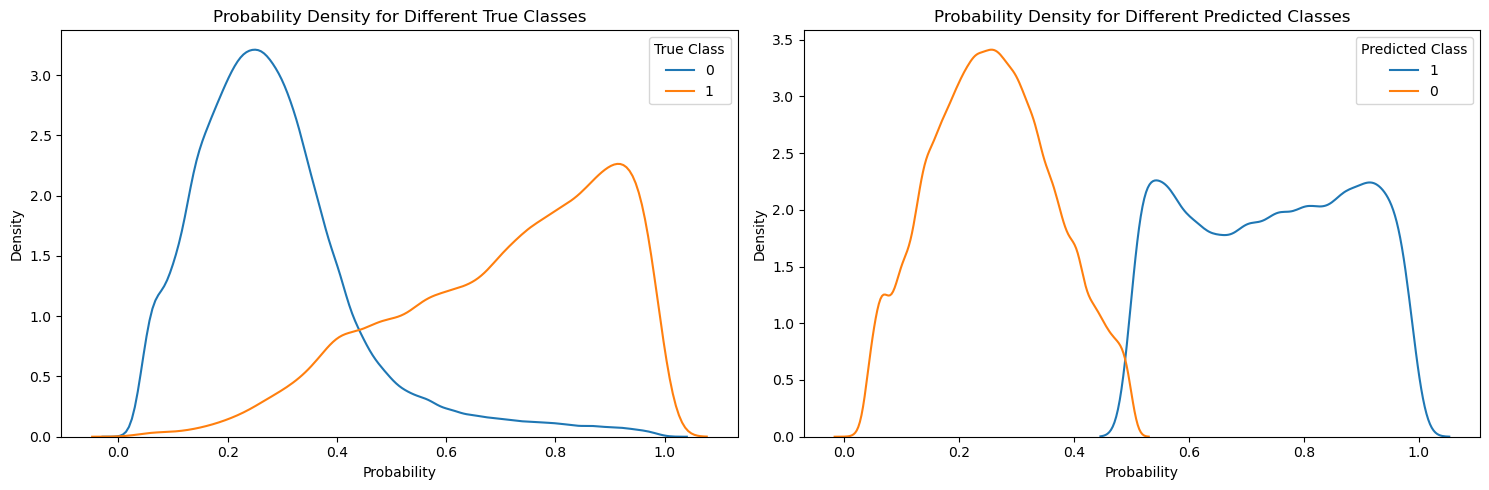

In [10]:
# get the results
y_pred = clf.predict(X_dev.toarray())
y_pred_proba = clf.predict_proba(X_dev.toarray())

# Convert lists to arrays for further use
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

print("Train")
print("accuracy_score",accuracy_score(y_dev, y_pred))
print("balanced_accuracy_score",balanced_accuracy_score(y_dev, y_pred))
print("average_precision_score",average_precision_score(y_dev, y_pred))
print(classification_report(y_dev, y_pred))

c = Counter(y_pred)
print("Prediction", c.most_common(2))
c = Counter(y_dev)
print("Ground Truth",c.most_common(2))

prediction = pd.DataFrame(y_pred_proba)
prediction['result'] = y_pred

df = prediction.copy()
df.columns = ['neg', 'pos', 'class']
df['true'] = y_dev

fig, axs = plt.subplots(ncols=2, figsize=(15, 5)) # Adjust figsize as needed

# Plot Probability Density for Different True Classes
for class_label in df['true'].unique():
    sns.kdeplot(df[df['true'] == class_label]['pos'], label=class_label, ax=axs[0])

axs[0].set_title('Probability Density for Different True Classes')
axs[0].set_xlabel('Probability')
axs[0].set_ylabel('Density')
axs[0].legend(title='True Class')

# Plot Probability Density for Different Predicted Classes
for class_label in df['class'].unique():
    sns.kdeplot(df[df['class'] == class_label]['pos'], label=class_label, ax=axs[1])

axs[1].set_title('Probability Density for Different Predicted Classes')
axs[1].set_xlabel('Probability')
axs[1].set_ylabel('Density')
axs[1].legend(title='Predicted Class')

plt.tight_layout()
plt.show()